## Fuzzy C Means

In [ ]:
!pip install mpi4py
# !pip install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd # reading all required header files
import numpy as np
import random
import operator
import math
import matplotlib.pyplot as plt 
from scipy.stats import multivariate_normal
from sklearn.datasets import load_iris 
from mpi4py import MPI

In [ ]:
iris = load_iris()
df = pd.DataFrame(iris.data)

In [ ]:
df.head()

,0,1,2,3
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [ ]:
#deciding parameters
n=df.shape[0] #no of points in dataset
k=3 #no of clusters we want
d=df.shape[1] #dimension of data 
m=2 #fuzziness parameter
n

150

# **Necessary Functions**

# Intializing Random membership matrix



it will automatically converge after some iterations to correct value


In [ ]:
#intializing a random n*k matrix
def intializeMembership(k,n):
   weight = np.random.dirichlet(np.ones(k),n)
   weight_arr = np.array(weight)
   return weight_arr

Calculating Cluster Center
To calculate centroids for each cluster we apply the following formula:
centroidcalc.svg
 
m(fuzzy-ness) ranges from 1 to inf

In [ ]:
def computeCentroids(weight_arr,n,k,m):
  C=[]
  for i in range(k):
    #computing denominator
    weight_sum=np.power(weight_arr[:,i],m).sum()
    Cj=[]
    for x in range(d):
      #.values is used to get numpy representation
      #that is to aid in dot product with Wij^m
      numerator=(df.iloc[:,x].values*np.power(weight_arr[:,i],m)).sum()
      c_val=numerator/weight_sum;
      #each dimension fuzzy centroid according to fuzzyiness parameter
      Cj.append(c_val)
    C.append(Cj);
  return np.array(C)
 


# Calculating Distance matrix

In [ ]:
def distance_matrix(df,n,C):
  distanceMatrix=[]
  for i in range(n):
    #for each point we intialize empty matrix
    dj=[]
    for j in range(d):
      #finding distance of that point dimension to centroids dimensions
      d_val=(C[:,j]-df.iloc[i,j])**2
      dj.append(d_val)
    
    dj_sum=sum(np.array(dj),0)
    dj_sum=np.power(dj_sum,0.5)
    #adding it to array
    distanceMatrix.append(dj_sum.tolist())
  return np.array(distanceMatrix)

      

# Updating membership
membershipUpdate.svg

In [ ]:
def UpdateMembershipMatrix(distance,n,k):
  U=[]
  for i in range(n):
    nthrow=[]
    for j in range(k):
      d=distance[i,j]**2
      mat=d/(distance[i,:]**2)
      dval=sum(mat)
      dval=pow(1/dval,1/(m-1))
      nthrow.append(dval)
    U.append(nthrow)
  return np.array(U)

# Now parallezing the code!!!!

In [ ]:
comm = MPI.COMM_WORLD #creating processes
rank=comm.Get_rank();
size=comm.Get_size();
num_cols=k/size;

In [ ]:
def fuzzyLogic(U,k,n,d,m):
  comm = MPI.COMM_WORLD #creating processes
  rank=comm.Get_rank();
  size=comm.Get_size();
  num_cols=int(k/size);
  send_data=None
  if comm.rank==0:
    arrs=np.split(U,size,axis=1)
    raveled=[np.ravel(arr) for arr in arrs]
    send_data=np.concatenate(raveled)
  
  
  recvbuf=np.empty((n,num_cols),dtype=np.float64)
  comm.Scatterv(send_data,recvbuf,root=0)
  uj=recvbuf
  Cj=computeCentroids(uj,n,num_cols,m);
  
  comm.barrier();
  C=np.empty((k,d),dtype=np.float64);
  wj=int(n/size);
  # print('Rank: ',rank, ', recvbuf received:\n ',Cj)
  comm.Gatherv(Cj,C,root=0);
  #  print('Rank: ',rank, ', recvbuf received:\n ',C)
   #sending computed centers to all
  comm.Bcast( [C, MPI.DOUBLE] ,root=0)
  #creating some index rows to split already copied dataset
  send_data=None;
  if rank==0:
    index=0;
    l=[]
    for i in range(0,n,wj):
      l.append([i,i+wj]);
    send_data=np.array(l);

  recvbuf=np.zeros(2,dtype=np.int64)
  comm.Scatterv(send_data,recvbuf,root=0)
  #distance matrix calculation
  dist=distance_matrix(df.iloc[recvbuf[0]:recvbuf[1],:],wj,C)
  #updated weight matrix
  uf=UpdateMembershipMatrix(dist,wj,k)
  comm.Gatherv(uf,U,root=0);
  if rank==0:
     return np.array(U),C

  #now gather all matrixes

In [ ]:
U=intializeMembership(k,n)
threshold=0.1
for i in range(1):
  if i==0:   
    U,C=fuzzyLogic(U,k,n,d,m)
  else:
    U,C1=fuzzyLogic(U,k,n,d,m)
    j=distance_matrix(pd.DataFrame(C1),3,C)

    print("iteration",i,j[0][0],j[1][1],j[2][2])
    if(j[0][0]<threshold and j[1][1]<threshold and j[2][2]<threshold):
      break;
    else:
      C=C1

# np.sum(U,axis=0)

In [ ]:
U

array([[0.36231677, 0.34422358, 0.29345965],
       [0.36233295, 0.34443905, 0.29322801],
       [0.36058117, 0.34434309, 0.29507573],
       [0.36176257, 0.34507436, 0.29316307],
       [0.36168484, 0.34431952, 0.29399564],
       [0.36401801, 0.34458244, 0.29139955],
       [0.36079183, 0.34490687, 0.29430131],
       [0.36332698, 0.34479273, 0.29188028],
       [0.35969841, 0.34457968, 0.29572191],
       [0.36299933, 0.34466633, 0.29233433],
       [0.36282229, 0.34377308, 0.29340463],
       [0.36339643, 0.34540475, 0.29119882],
       [0.36162622, 0.34434794, 0.29402583],
       [0.35721463, 0.34356466, 0.29922071],
       [0.35786811, 0.34149591, 0.30063599],
       [0.35750663, 0.34204451, 0.30044886],
       [0.36013538, 0.34319333, 0.29667129],
       [0.36256007, 0.34439844, 0.29304149],
       [0.3641784 , 0.34348332, 0.29233828],
       [0.3621203 , 0.34450638, 0.29337332],
       [0.36659506, 0.34469136, 0.28871358],
       [0.36286647, 0.34479485, 0.29233868],
       [0.

In [ ]:
df_sepal = df.iloc[:,0:2]
df_petal = df.iloc[:,2:5]

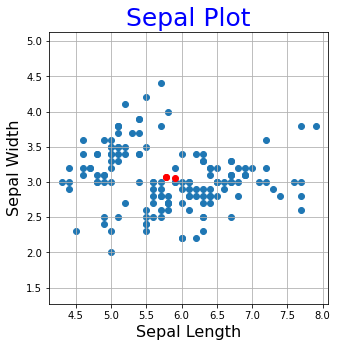

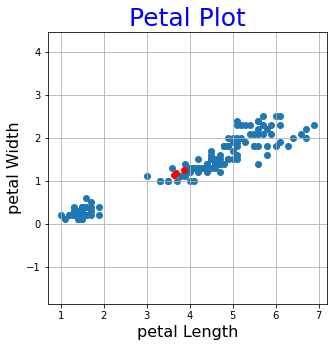

In [ ]:
plt.figure(0,figsize=(5,5))                #scatter plot of sepal length vs sepal width                              
plt.scatter(list(df_sepal.iloc[:,0]), list(df_sepal.iloc[:,1]), marker='o')       
plt.axis('equal')                                                                 
plt.xlabel('Sepal Length', fontsize=16)                                                 
plt.ylabel('Sepal Width', fontsize=16)                                                 
plt.title('Sepal Plot', fontsize=25,color='b')                                            
plt.grid() 
for center in C:
  plt.scatter(center[0],center[1], marker='o',color='r')                                                                
plt.show()

plt.figure(1,figsize=(5,5))                #scatter plot of sepal length vs sepal width                              
plt.scatter(list(df_petal.iloc[:,0]), list(df_petal.iloc[:,1]), marker='o')       
plt.axis('equal')                                                                 
plt.xlabel('petal Length', fontsize=16)                                                 
plt.ylabel('petal Width', fontsize=16)                                                 
plt.title('Petal Plot', fontsize=25,color='b')                                            
plt.grid()                     
for center in C:
  plt.scatter(center[2],center[3], marker='o',color='r')                                                       
plt.show()

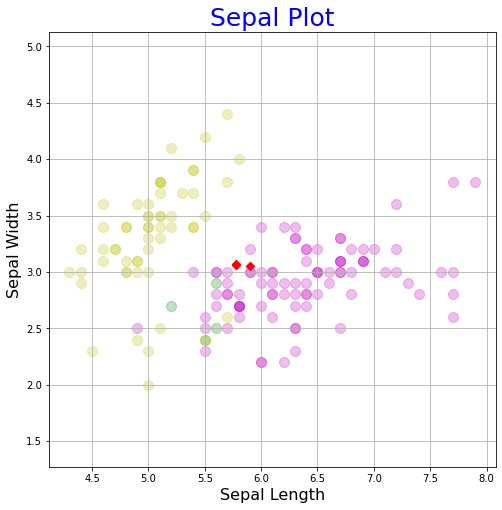

In [ ]:
X = np.zeros((n,1))
plt.figure(0,figsize=(8,8))                #scatter plot of sepal length vs sepal width                                     
plt.axis('equal')                                                                 
plt.xlabel('Sepal Length', fontsize=16)                                                 
plt.ylabel('Sepal Width', fontsize=16)                                                 
plt.title('Sepal Plot', fontsize=25,color='b')                                            
plt.grid() 
for center in C:
  plt.scatter(center[0],center[1], marker='D',color='r')                                                                
clr = 'b'
for i in range(n):    
    cNumber = np.where(U[i] == np.amax(U[i]))
    if cNumber[0][0]==0:
      clr = 'y'
    elif cNumber[0][0]==1:
      clr = 'g'
    elif cNumber[0][0]==2:
      clr = 'm'
    plt.scatter(list(df_sepal.iloc[i:i+1,0]), list(df_sepal.iloc[i:i+1,1]), alpha=0.25,s=100,color=clr)
plt.show()

In [ ]:
U.shape

(150, 3)